In [2]:
import nilearn as nl
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from os import walk
import numpy as np
import seaborn as sns
sns.set("paper", "white")
%matplotlib inline
from nilearn import plotting
import hcp_utils as hcp
import nibabel as nb
from plotting import decompose_dscalar, plot_dscalar
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
cleanpath='../data/cifti/cleaned/smoothed/'
subject_flist = list(walk(cleanpath))[0][2:][0]

In [4]:
#load the cifti2 to steal the header
img_dir = '/om2/user/jsmentch/projects/speech_face_analysis/data/fitlins_cifti/fitlins/sub-19/'
img_name = 'sub-19_task-MerlinMovie_space-fsLR_contrast-faceAndSpeech_stat-t_statmap.dscalar.nii'
img = nb.load(img_dir+img_name)

#load union of 100% coverage
union_ind = np.load('data/subject_union_ind.npy') #100% coverage of all sujbects


In [5]:
A_ = np.load('data/fast_ICA_AC_A.npy')
S_ = np.load('data/fast_ICA_AC_S.npy')

class_names = np.load('/om2/user/jsmentch/data/yamnet_output/yamnet_class_names.npy')
as_classes_label = np.zeros((521),dtype='S30')
as_classes = np.zeros((521))


as_classes[0:66]=0
as_classes[66:132]=1
as_classes[132:277]=2
as_classes[277:294]=3
as_classes[294:453]=4
as_classes[453:500]=5
as_classes[500:]=6

as_classes_label[0:66]='Human Sounds'
as_classes_label[66:132]='Animal'
as_classes_label[132:277]='Music'
as_classes_label[277:294]='Natural Sounds'
as_classes_label[294:453]='Sounds of Things'
as_classes_label[453:500]='Source Ambiguous Sounds'
as_classes_label[500:]='Channel, Environment, Background'

labels=['Human Sounds','Animal','Music','Natural Sounds','Sounds of Things','Source Ambiguous Sounds','Channel, Environment, Background']

In [6]:
roi_l=f'/om2/user/jsmentch/data/rois/svnh_ROIS_anatlabels_surf_mni/fsLR_32k_posterior2anterior/lh.stp-aud-pm2al-r1of5.label.gii'
roi_l_gii=nb.load(roi_l)
roi_l_sum = roi_l_gii.agg_data()

roi_r=f'/om2/user/jsmentch/data/rois/svnh_ROIS_anatlabels_surf_mni/fsLR_32k_posterior2anterior/rh.stp-aud-pm2al-r1of5.label.gii'
roi_r_gii=nb.load(roi_r)
roi_r_sum = roi_r_gii.agg_data()

for s in [2, 3, 4, 5]:
    roi_r=f'/om2/user/jsmentch/data/rois/svnh_ROIS_anatlabels_surf_mni/fsLR_32k_posterior2anterior/rh.stp-aud-pm2al-r{s}of5.label.gii'
    roi_r_gii=nb.load(roi_r)
    roi_r_sum = roi_r_sum + roi_r_gii.agg_data()
    
    roi_l=f'/om2/user/jsmentch/data/rois/svnh_ROIS_anatlabels_surf_mni/fsLR_32k_posterior2anterior/lh.stp-aud-pm2al-r{s}of5.label.gii'
    roi_l_gii=nb.load(roi_l)
    roi_l_sum = roi_l_sum + roi_l_gii.agg_data()
roi_lh = np.append(roi_l_sum, roi_r_sum)
roi_r_91k=roi_r_sum[hcp.vertex_info.grayr]
roi_l_91k=roi_l_sum[hcp.vertex_info.grayl]

roi_60k = np.hstack((roi_l_91k,roi_r_91k))
roi_91k = np.zeros(91282)
roi_91k[0:59412]=roi_60k # bilateral AC ROI in 91k space

roi_91k_ind = np.squeeze(np.argwhere(roi_91k==1)) #indices of the AC voxels

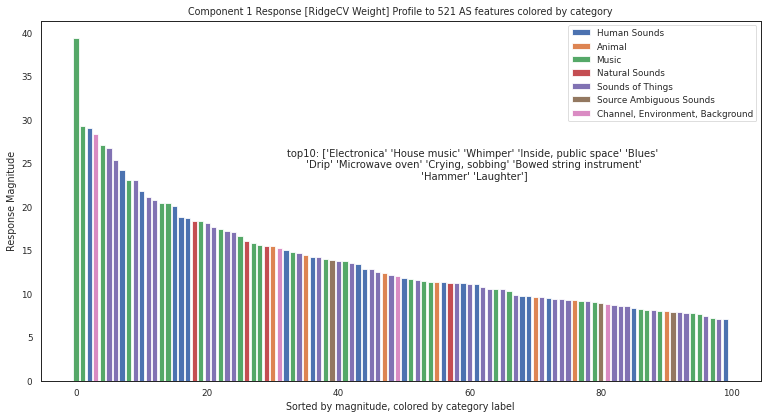

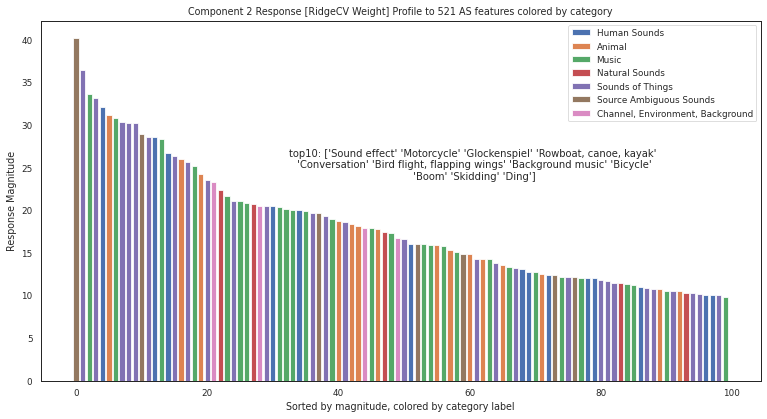

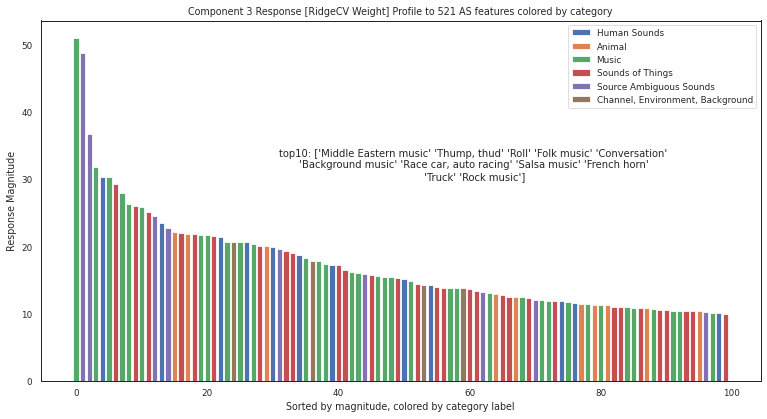

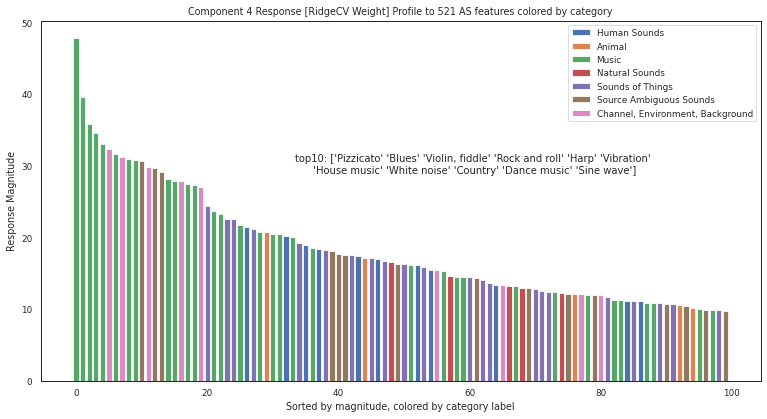

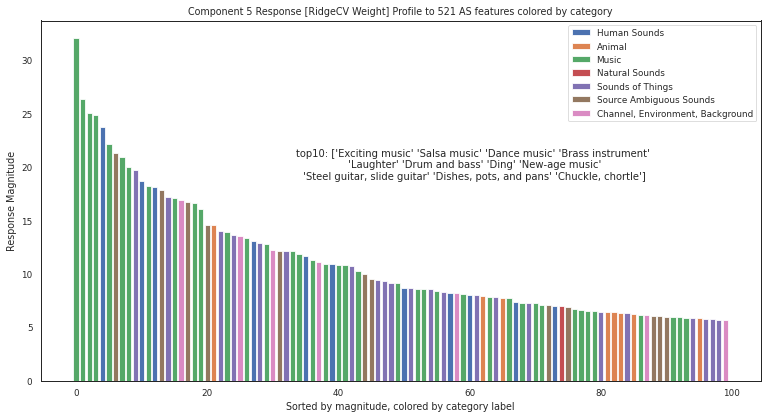

In [7]:
for c in np.arange(5):
    c1_response = A_[:,c]
    c1_ind = np.argsort(c1_response)[::-1]
    c1_response_sorted = c1_response[c1_ind]
    c1_category_sorted = as_classes[c1_ind]
    c1_category_str_sorted = as_classes_label[c1_ind]

    top_components=100
    x_cat_str = c1_category_str_sorted[0:top_components]
    x_cat = c1_category_sorted[0:top_components]
    x_val = c1_response_sorted[0:top_components]
    x_pos = np.array([i for i, _ in enumerate(x_val)])
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_axes([0, 0, 1, 1])
    for i in np.arange(7):
        cat_ind = np.squeeze(np.where(x_cat == i)[0])
        if cat_ind.any():
            plt.bar(x_pos[cat_ind], x_val[cat_ind],label=labels[i])

    plt.xlabel("Sorted by magnitude, colored by category label")
    plt.ylabel("Response Magnitude")
    plt.title(f"Component {c+1} Response [RidgeCV Weight] Profile to 521 AS features colored by category")
    plt.legend()
    plt.text(0.6, 0.6, 'top10: '+str(class_names[c1_ind][0:11]), fontsize=10, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

In [8]:
S_.max()

0.15979233396501513

In [14]:
# components 4 and 5 look like music - plot them!
c=4 # 0 is comopnent 1, 4 is component 5 etc
for i in np.arange(18):
    print(i)
    current_ac = S_[i*1699:(i+1)*1699,c]


    r2_91k_ridgecv = np.zeros(91282)
    r2_91k_ridgecv[:] = 0
    r2_91k_ridgecv[roi_91k_ind] = current_ac[:len(roi_91k_ind)]

    #plot one subject trained on 1 tested on 1 Ridge
    fig = plt.figure(figsize=(20,20))
    plotting.plot_surf(hcp.mesh.flat, hcp.cortex_data(r2_91k_ridgecv), threshold=0.0001, vmin=0, vmax = 0.05, title = f'AC_component{c+1}_sub{i+1}', colorbar=True, bg_map=hcp.mesh.sulc, figure = fig, output_file=f'AC_component{c+1}/AC_component{c+1}_sub{i+1}.png')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


### What about plotting the mean response of each 

In [15]:
S_.shape

(30582, 521)

In [65]:
S_re = S_.reshape(18,1699,521)

In [66]:
mean_S_ = S_re.mean(axis=0) #sanity checked this w/dummy example it averages over subejcts

In [71]:
c = 5
current_ac = mean_S_[:,c]
r2_91k_ridgecv = np.zeros(91282)
r2_91k_ridgecv[:] = 0
r2_91k_ridgecv[roi_91k_ind] = current_ac[:len(roi_91k_ind)]

#plot one subject trained on 1 tested on 1 Ridge
fig = plt.figure(figsize=(20,20))
plotting.plot_surf(hcp.mesh.flat, hcp.cortex_data(r2_91k_ridgecv), threshold=0.0001, vmin=0, title = f'mean_AC_component{c+1}', colorbar=True, bg_map=hcp.mesh.sulc, figure = fig, output_file=f'mean_AC_component{c+1}.png')

#does it make sense to zscore each subject?